<a href="https://colab.research.google.com/github/Harshit0502/MelodyMind/blob/main/MelodyMind.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import warnings
from sklearn.preprocessing import StandardScaler
import math


In [2]:
data = pd.read_csv('/content/sample_data/data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170653 non-null  float64
 1   year              170653 non-null  int64  
 2   acousticness      170653 non-null  float64
 3   artists           170653 non-null  object 
 4   danceability      170653 non-null  float64
 5   duration_ms       170653 non-null  int64  
 6   energy            170653 non-null  float64
 7   explicit          170653 non-null  int64  
 8   id                170653 non-null  object 
 9   instrumentalness  170653 non-null  float64
 10  key               170653 non-null  int64  
 11  liveness          170653 non-null  float64
 12  loudness          170653 non-null  float64
 13  mode              170653 non-null  int64  
 14  name              170653 non-null  object 
 15  popularity        170653 non-null  int64  
 16  release_date      17

In [3]:
data.shape

(170653, 19)

In [4]:
data.isnull().sum()

,0
valence,0
year,0
acousticness,0
artists,0
danceability,0
duration_ms,0
energy,0
explicit,0
id,0
instrumentalness,0


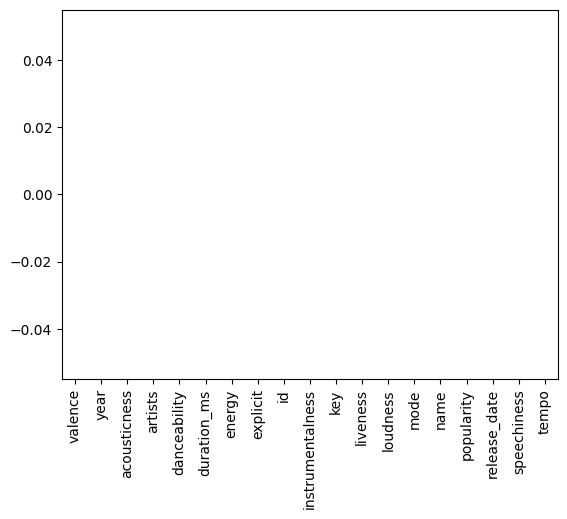

In [5]:
data.dropna(inplace = True)
data.isnull().sum().plot.bar()
plt.show()

In [6]:
if 'id' in data.columns:
    data = data.drop(['id'], axis=1)

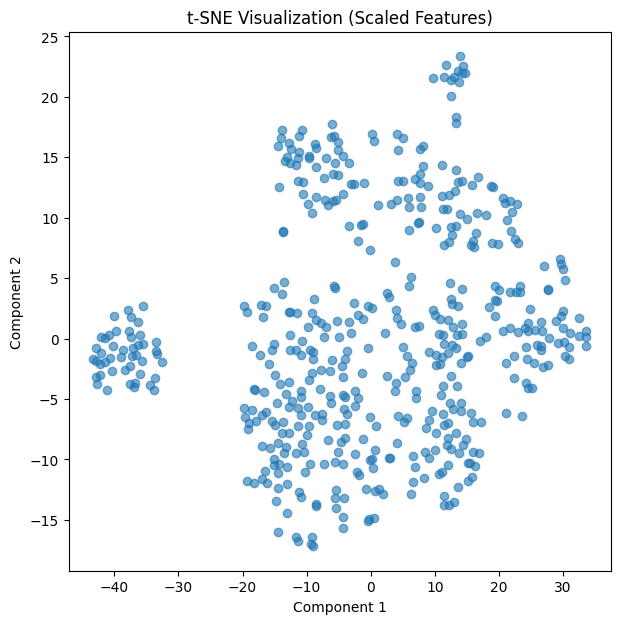

In [7]:
# Select numerical columns only
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns

# Take random 500 samples (or less if not enough rows)
subset_data = data[numerical_columns].sample(n=min(500, len(data)), random_state=0)

# Standardize the numerical features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(subset_data)

# Apply t-SNE
tsne_model = TSNE(n_components=2, random_state=0, perplexity=30)
tsne_data = tsne_model.fit_transform(scaled_data)

# Plot t-SNE
plt.figure(figsize=(7, 7))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], alpha=0.6)
plt.title("t-SNE Visualization (Scaled Features)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

In [8]:
data = data.sort_values(by=['popularity'], ascending=False)
data.drop_duplicates(subset=['name'], keep='first', inplace=True)
unique_song_count = data['name'].nunique()
total_rows = data.shape[0]
print(f"🎵 Unique Songs after cleaning: {unique_song_count}")
print(f"🗃️ Total Records after cleaning: {total_rows}")

🎵 Unique Songs after cleaning: 133638
🗃️ Total Records after cleaning: 133638


<ipython-input-9-257b00a12a21>:18: UserWarning: Glyph 127926 (\N{MULTIPLE MUSICAL NOTES}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127926 (\N{MULTIPLE MUSICAL NOTES}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


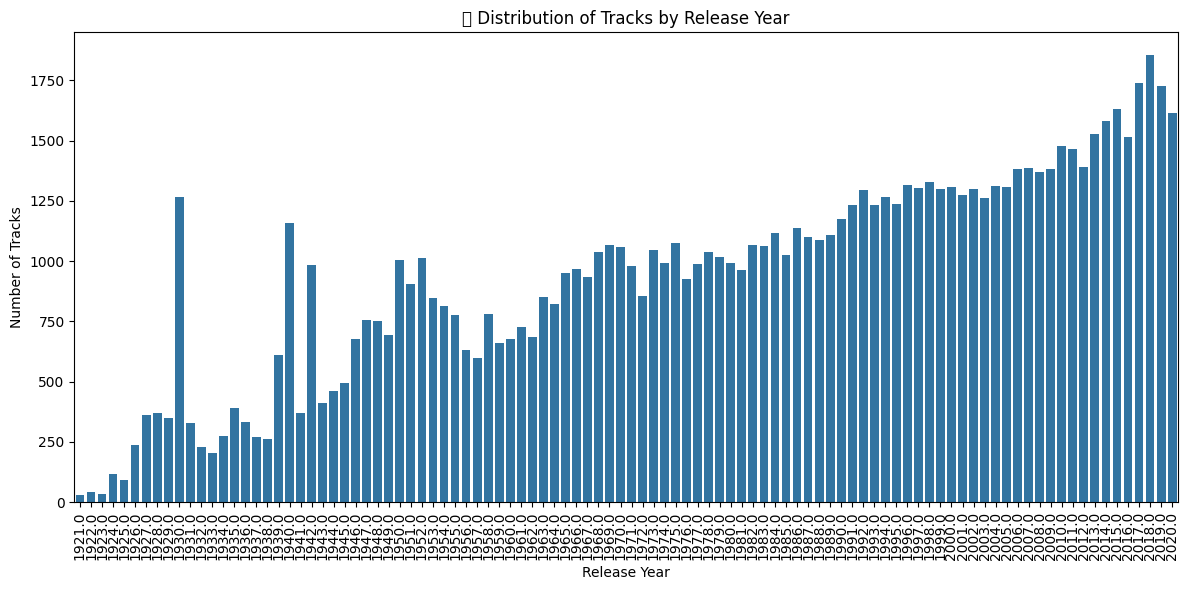

In [9]:
# Ensure 'release_year' exists and convert it to datetime
if 'release_year' not in data.columns:
    data['release_year'] = pd.to_datetime(data['release_date'], errors='coerce').dt.year

# Drop missing years
release_year_data = data.dropna(subset=['release_year'])

# Sort years ascending
year_order = sorted(release_year_data['release_year'].dropna().unique())

# Plot the release year distribution
plt.figure(figsize=(12, 6))
sb.countplot(data=release_year_data, x='release_year', order=year_order)
plt.xticks(rotation=90)
plt.title("🎶 Distribution of Tracks by Release Year")
plt.xlabel("Release Year")
plt.ylabel("Number of Tracks")
plt.tight_layout()
plt.show()

In [10]:
# More correct and faster float column selection
floats = [col for col in data.columns if np.issubdtype(data[col].dtype, np.floating)]
print(f"✅ Number of float columns: {len(floats)}")


✅ Number of float columns: 10


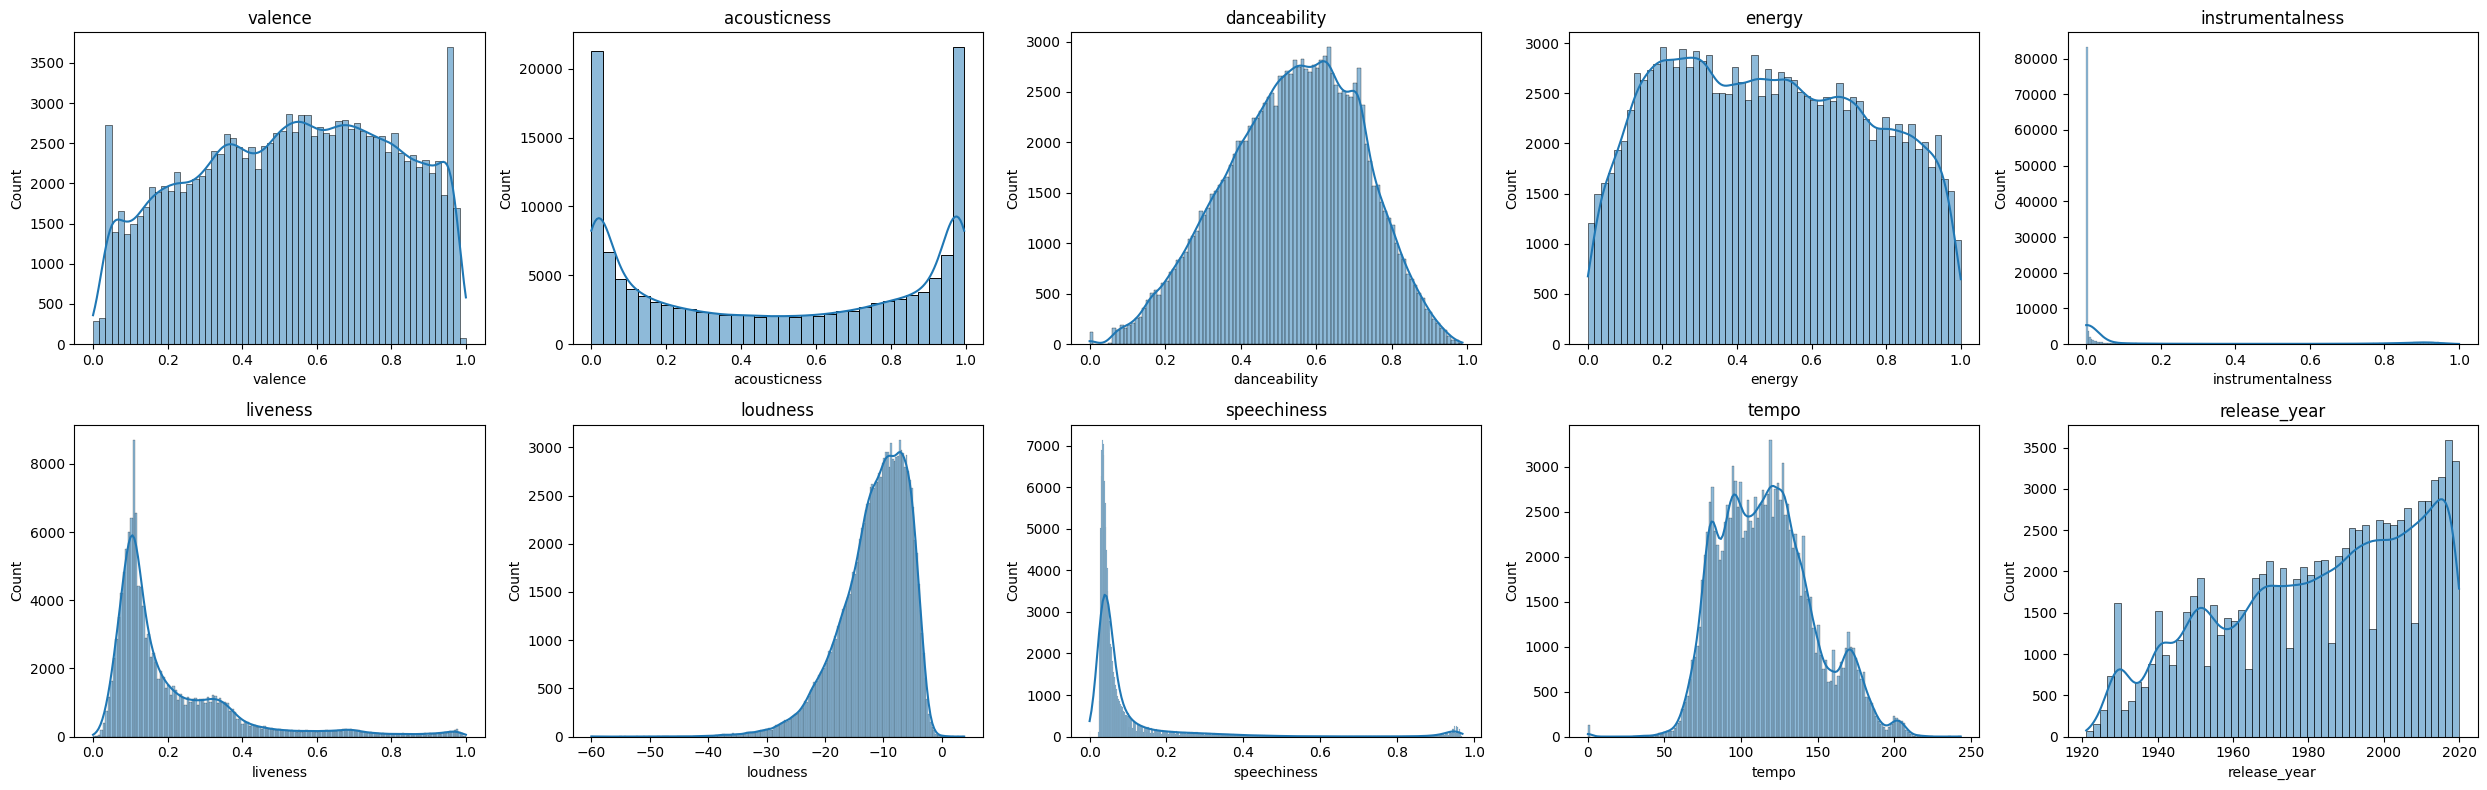

In [11]:
# Number of float columns
num_floats = len(floats)

# Dynamically calculate number of rows and columns
cols = 5
rows = math.ceil(num_floats / cols)

# Create figure
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()  # Flatten in case of multiple rows

# Plot each float column
for i, col in enumerate(floats):
    sb.histplot(data[col], kde=True, ax=axes[i])
    axes[i].set_title(col)

# Hide any extra subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [12]:
# 1. Categorize danceability
def categorize_danceability(value):
    if value < 0.4:
        return "Low Danceability"
    elif value < 0.7:
        return "Medium Danceability"
    else:
        return "High Danceability"

data['danceability_category'] = data['danceability'].apply(categorize_danceability)

# 2. Initialize and fit CountVectorizer
song_vectorizer = CountVectorizer(lowercase=True)
song_vectorizer.fit(data['danceability_category'])

CountVectorizer()

In [13]:
def precompute_features(data, song_vectorizer):
    """
    Precompute numeric and text features for the entire dataset.

    Args:
        data (pd.DataFrame): The input music dataset.
        song_vectorizer (CountVectorizer): Fitted CountVectorizer instance.

    Returns:
        text_vectors (np.ndarray): Text feature matrix.
        numeric_vectors (np.ndarray): Numerical feature matrix.
    """
    # Safety check
    assert 'danceability_category' in data.columns, "Danceability category not found. Run categorization first."

    # Precompute text vectors
    text_vectors = song_vectorizer.transform(data['danceability_category']).toarray()

    # Precompute numeric feature vectors
    numeric_data = data.select_dtypes(include=np.number)
    numeric_data = numeric_data.fillna(numeric_data.mean())
    numeric_vectors = numeric_data.to_numpy()

    return text_vectors, numeric_vectors

In [14]:
def get_similarities_optimized(song_name: str, data: pd.DataFrame, text_vectors: np.ndarray, numeric_vectors: np.ndarray) -> np.ndarray:
    """
    Calculate similarity scores in a vectorized manner.

    Args:
        song_name (str): Name of the input song.
        data (pd.DataFrame): Dataset containing songs.
        text_vectors (np.ndarray): Precomputed text features.
        numeric_vectors (np.ndarray): Precomputed numeric features.

    Returns:
        np.ndarray: Combined similarity scores for all songs.
    """
    # Find the index of the input song
    song_index = data.index[data['name'] == song_name].tolist()
    if not song_index:
        raise ValueError(f"Song '{song_name}' not found in the dataset.")
    song_index = song_index[0]

    # Get the input song's text and numeric vectors
    text_array1 = text_vectors[song_index]
    num_array1 = numeric_vectors[song_index]

    # Calculate cosine similarity for all songs
    text_sim = cosine_similarity([text_array1], text_vectors).flatten()
    num_sim = cosine_similarity([num_array1], numeric_vectors).flatten()

    # Combine similarities (currently equal weight)
    total_similarity = text_sim + num_sim

    return total_similarity


In [15]:
def recommend_songs_optimized(song_name: str, data: pd.DataFrame, text_vectors: np.ndarray, numeric_vectors: np.ndarray) -> pd.DataFrame:
    """
    Recommend songs similar to a given input song.

    Args:
        song_name (str): Name of the input song.
        data (pd.DataFrame): Dataset containing songs.
        text_vectors (np.ndarray): Precomputed text features.
        numeric_vectors (np.ndarray): Precomputed numeric features.

    Returns:
        pd.DataFrame: Top 5 recommended songs excluding the input song.
    """
    # Check if the song exists
    song_indices = data.index[data['name'] == song_name].tolist()
    if not song_indices:
        raise ValueError(f"Song '{song_name}' not found in the dataset.")

    # Get similarity scores
    similarities = get_similarities_optimized(song_name, data, text_vectors, numeric_vectors)

    # Add similarity scores (without modifying original data)
    temp_data = data.copy()
    temp_data['similarity_factor'] = similarities

    # Sort and select top 5 recommendations (excluding the input song)
    recommendations = temp_data.sort_values(by=['similarity_factor', 'popularity'], ascending=[False, False])
    recommendations = recommendations[['name', 'artists']][1:6]  # Skip the first song (input song itself)

    return recommendations

In [16]:
def recommend_songs_optimized(song_name: str, data: pd.DataFrame, text_vectors: np.ndarray, numeric_vectors: np.ndarray) -> pd.DataFrame:
    """
    Recommend songs similar to a given input song.

    Args:
        song_name (str): Name of the input song.
        data (pd.DataFrame): Dataset containing songs.
        text_vectors (np.ndarray): Precomputed text features.
        numeric_vectors (np.ndarray): Precomputed numeric features.

    Returns:
        pd.DataFrame: Top 5 recommended songs excluding the input song.
    """
    # Check if the song exists
    song_indices = data.index[data['name'] == song_name].tolist()
    if not song_indices:
        raise ValueError(f"Song '{song_name}' not found in the dataset.")

    # Get similarity scores
    similarities = get_similarities_optimized(song_name, data, text_vectors, numeric_vectors)

    # Create a temporary copy to avoid modifying original data
    temp_data = data.copy()
    temp_data['similarity_factor'] = similarities

    # Sort and select top 5 recommendations (excluding the input song)
    recommendations = temp_data.sort_values(by=['similarity_factor', 'popularity'], ascending=[False, False])
    recommendations = recommendations[['name', 'artists']][1:6]  # Skip the first song (input song itself)

    return recommendations


In [17]:
def assign_mood(row):
    if row['energy'] > 0.7 and row['danceability'] > 0.6:
        return 'Energetic'
    elif row['valence'] > 0.6:
        return 'Happy'
    elif row['valence'] < 0.3 and row['energy'] < 0.5:
        return 'Sad'
    elif row['energy'] < 0.4 and row['danceability'] < 0.5:
        return 'Calm'
    elif 0.4 <= row['valence'] <= 0.6 and row['energy'] < 0.6:
        return 'Romantic'
    else:
        return 'Other'

# Apply mood assignment
data['mood'] = data.apply(assign_mood, axis=1)


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 133638 entries, 19611 to 59600
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   valence                133638 non-null  float64
 1   year                   133638 non-null  int64  
 2   acousticness           133638 non-null  float64
 3   artists                133638 non-null  object 
 4   danceability           133638 non-null  float64
 5   duration_ms            133638 non-null  int64  
 6   energy                 133638 non-null  float64
 7   explicit               133638 non-null  int64  
 8   instrumentalness       133638 non-null  float64
 9   key                    133638 non-null  int64  
 10  liveness               133638 non-null  float64
 11  loudness               133638 non-null  float64
 12  mode                   133638 non-null  int64  
 13  name                   133638 non-null  object 
 14  popularity             133638 non-null

In [19]:
from sklearn.cluster import KMeans

# Select important numeric features for clustering
cluster_features = data[['danceability', 'energy', 'valence', 'tempo', 'acousticness']].fillna(0)

# Standardize features (very important for clustering)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(cluster_features)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=0)  # 5 clusters (you can tune later)
cluster_labels = kmeans.fit_predict(scaled_features)

# Add cluster labels to dataset
data['cluster'] = cluster_labels

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
<ipython-input-20-92cdc7b64137>:41: UserWarning: Glyph 127926 (\N{MULTIPLE MUSICAL NOTES}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127926 (\N{MULTIPLE MUSICAL NOTES}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


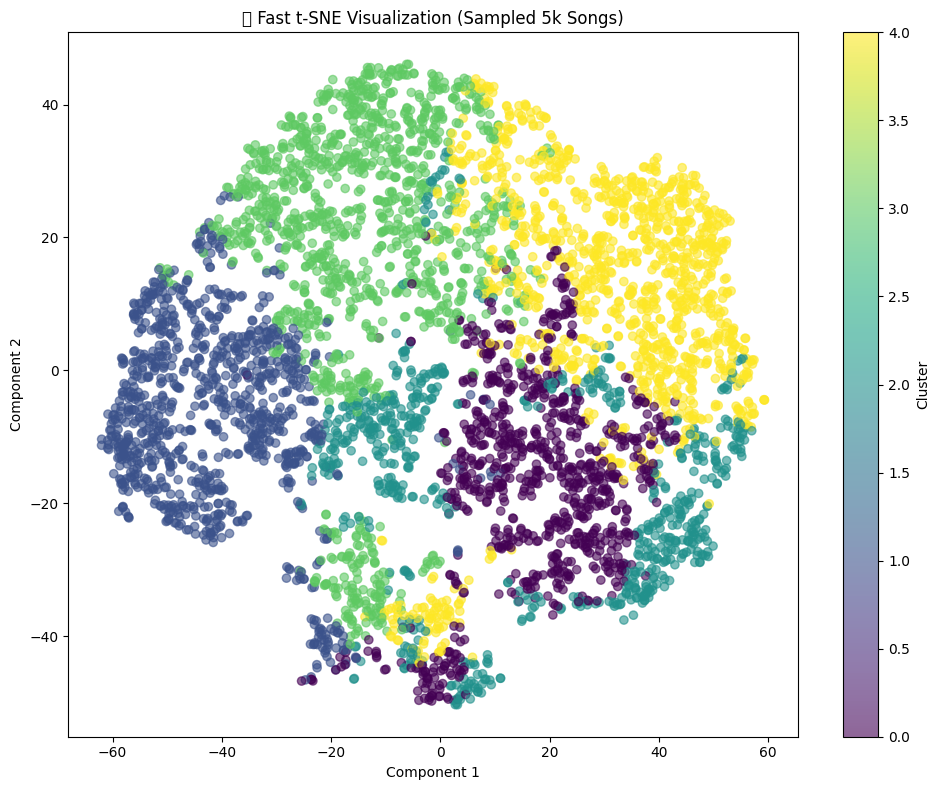

In [20]:
# -------------------------------
# Step 1: Downsample the data safely
# -------------------------------
# Randomly select 5000 points for t-SNE (fast and meaningful)
sample_size = 5000  # You can increase to 10,000 if very high RAM
data_sample = data.sample(n=sample_size, random_state=42)

# -------------------------------
# Step 2: Prepare the features
# -------------------------------
tsne_features = data_sample[['danceability', 'energy', 'valence', 'tempo', 'acousticness', 'liveness']].fillna(0)

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(tsne_features)

# -------------------------------
# Step 3: Apply Fast t-SNE
# -------------------------------
tsne_model = TSNE(
    n_components=2,
    perplexity=50,           # Higher perplexity for larger datasets
    n_iter=1000,             # Fewer iterations (default is 1000)
    learning_rate='auto',
    init='pca',              # PCA init helps faster convergence
    random_state=42,
    method='barnes_hut'      # Default Barnes-Hut t-SNE (fast)
)

tsne_data = tsne_model.fit_transform(scaled_features)

# -------------------------------
# Step 4: Plot the result
# -------------------------------
plt.figure(figsize=(10, 8))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=data_sample['cluster'], cmap='viridis', alpha=0.6)
plt.colorbar(label='Cluster')
plt.title('🎶 Fast t-SNE Visualization (Sampled 5k Songs)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.tight_layout()
plt.show()


In [21]:
def precompute_features(data: pd.DataFrame, song_vectorizer) -> tuple:
    """
    Precompute numeric and text feature vectors for the entire dataset.

    Args:
        data (pd.DataFrame): Cleaned music dataset with mood and cluster.
        song_vectorizer (CountVectorizer): Trained CountVectorizer for text features.

    Returns:
        tuple: (text_vectors, numeric_vectors)
    """
    # Safety check
    assert 'danceability_category' in data.columns, "Danceability category not found."

    # Precompute text vectors
    text_vectors = song_vectorizer.transform(data['danceability_category']).toarray()

    # Precompute numeric feature vectors
    numeric_data = data.select_dtypes(include=[np.number]).copy()

    # (Optional) Drop 'cluster' if you don't want it to influence similarity
    if 'cluster' in numeric_data.columns:
        numeric_data = numeric_data.drop(columns=['cluster'])

    # (Optional) Drop 'release_year' if you don't want it to influence similarity
    if 'release_year' in numeric_data.columns:
        numeric_data = numeric_data.drop(columns=['release_year'])

    # Fill any missing numeric values safely
    numeric_data = numeric_data.fillna(numeric_data.mean())

    numeric_vectors = numeric_data.to_numpy()

    return text_vectors, numeric_vectors


In [22]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def get_similarities_optimized(song_name: str, data: pd.DataFrame, text_vectors: np.ndarray, numeric_vectors: np.ndarray) -> np.ndarray:
    """
    Calculate similarity scores between the given song and all songs.

    Args:
        song_name (str): Input song name.
        data (pd.DataFrame): Dataset with songs.
        text_vectors (np.ndarray): Precomputed text feature matrix.
        numeric_vectors (np.ndarray): Precomputed numeric feature matrix.

    Returns:
        np.ndarray: Combined similarity scores.
    """
    # Find the index of the input song
    song_indices = data.index[data['name'] == song_name].tolist()
    if not song_indices:
        raise ValueError(f"Song '{song_name}' not found in the dataset.")
    song_index = song_indices[0]

    # Get input song's vectors
    text_array1 = text_vectors[song_index]
    num_array1 = numeric_vectors[song_index]

    # Calculate cosine similarities
    text_sim = cosine_similarity([text_array1], text_vectors).flatten()
    num_sim = cosine_similarity([num_array1], numeric_vectors).flatten()

    # Combine similarities equally (simple addition)
    total_similarity = text_sim + num_sim

    return total_similarity

In [24]:
import joblib

# Call precompute_features to create text_vectors and numeric_vectors
text_vectors, numeric_vectors = precompute_features(data, song_vectorizer)

# -------------------------------
# Saving Core Models
# -------------------------------

# 1. Save the fitted CountVectorizer
joblib.dump(song_vectorizer, 'song_vectorizer.pkl')

# 2. Save precomputed text feature matrix
joblib.dump(text_vectors, 'text_vectors.pkl')

# 3. Save precomputed numeric feature matrix
joblib.dump(numeric_vectors, 'numeric_vectors.pkl')

# 4. Save cleaned dataset with mood and cluster
joblib.dump(data, 'data.pkl')

# -------------------------------
# Saving Minor (Optional but Professional) Models
# -------------------------------

# 5. Save the trained KMeans clustering model
joblib.dump(kmeans, 'kmeans_model.pkl')

# 6. Save the trained StandardScaler for clustering
joblib.dump(scaler, 'scaler.pkl')

# 7. Save the t-SNE 2D map (optional visualization)
joblib.dump(tsne_data, 'tsne_data.pkl')

print("✅ All models and artifacts saved successfully using joblib.")

✅ All models and artifacts saved successfully using joblib.
